# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Local Setup

#### ⚠️ Note:
If you are running this starting kit locally, you may want to use a dedicated conda env.  
[Instructions to setup a conda env](https://github.com/FAIR-Universe/HEP-Challenge/tree/master/conda)

#### ⚠️ Note:
If you are running this starting kit on MAC OS, you may want to check and install `libomp` package. 
This package is needed to run xgboost model. Follow the steps below for complete installations.

If still you are facing problems with XGBoost, you can uninstall the current xgboost and install py-xgboost in your environment

Uninstall XGBoost
```
pip uninstall xgboost
```

Install py-xgboost using conda
```
conda install py-xgboost
```

`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/HEP-Challenge.git

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

    # Install required packages
    # %pip install -r conda/requirements.txt 

### Dummy_Submission
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

### Imports

In [3]:
import os
import json
import datetime
import numpy as np
from sys import path
from zipfile import ZipFile, ZIP_DEFLATED
from contextlib import closing

### Directories

In [4]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

# The directory of the input data
input_dir = os.path.join(root_dir, "input_data")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission") 

# The directory of the ingestion program 
program_dir = os.path.join(root_dir, "ingestion_program") 

# The directory of the scoring program
score_dir = os.path.join(root_dir, "scoring_program")

# Add the directory to the path
path.append(program_dir) 
path.append(score_dir)

Root directory is /data/atlas/chakkappai/FairUniverse/HEP-Challenge


In [5]:
from systematics import systematics # import the systematics function from the ingestion program

***
## Data
***

⚠️ Note:

By default the repository has a sample dataset at [input_data](/input_data/). This is a small sample data is for demonstration only to get a view of what the data looks like.

For Training and inference you may want to use the much Bigger public dataset. For this set `USE_PUBLIC_DATASET` to `True` and the code below uses the  `Neurips2024_public_dataset()` funtion in the `dataset` module to download and read the public dataset. else the code loads the small sample data for quick execution of this notebook


⚠️ Note:

If you have already downloaded the public_data from the competition website, make sure that it is placed in the right folder `HEP-Challenge/` so that you don't download it again. Setting `USE_PUBLIC_DATASET` to `True` will download the public_data if not found in the `HEP-Challenge` directory.

In [6]:
USE_PUBLIC_DATASET = False

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [7]:
from datasets import Data # import the Data class from the ingestion program

if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [8]:
# load train set
data.load_train_set() # load the training set to memory, this may take a few seconds

2024-09-16 18:43:27,777 - datasets             - INFO     - Train data loaded successfully


In [9]:
# load test sets
data.load_test_set() # load the test set to memory, this may take a few seconds

2024-09-16 18:43:27,815 - datasets             - INFO     - Test data loaded successfully


***
## Visualize
***
The purpose of the `Dataset_visualise` class is to visulaise the training dataset,
data is the dictionary of different fields like dataframe, label, weights etc. upon initiallisation you will see a table of these fields

Initialisation you can give a list a columns of Data you are interested to have plots for. If no inputs are given then all the columns of the DataFrame are taken

In [10]:
import visualization as viz

data_vis = data.get_train_set()
 
# when No systematics parameters are passed, the systematics function will return the original dataset with post process cuts
data_vis = systematics(data_vis) 
train_visualize = viz.Dataset_visualise(
    data_set=data_vis,
    columns=[
        "PRI_met",
        "PRI_had_pt",
        "DER_mass_vis",
        "DER_mass_transverse_met_lep",
        "DER_deltar_had_lep",

    ],
    name="Train Set",
)


General Structure of the data object is a dictionary
+-----------------+---------------------------------+-------------------------------------+
| Key             | Value                           | Type                                |
+=================+=================================+=====================================+
| labels          | Array of shape (198748,)        | <class 'pandas.core.series.Series'> |
+-----------------+---------------------------------+-------------------------------------+
| weights         | Array of shape (198748,)        | <class 'pandas.core.series.Series'> |
+-----------------+---------------------------------+-------------------------------------+
| detailed_labels | Array of shape (198748,)        | <class 'pandas.core.series.Series'> |
+-----------------+---------------------------------+-------------------------------------+
| data            | DataFrame of shape (198748, 28) | DataFrame                           |
+-----------------+-------

The `examine_dataset` methods give you more general infomation as tables to give an idea of the general nature of the training data

In [11]:
# Show data summary
train_visualize.examine_dataset()


+--------------------+-----------+
| Key                | Value     |
+====================+===========+
| Dataset name       | Train Set |
+--------------------+-----------+
| Number of events   | 198748    |
+--------------------+-----------+
| Number of features | 28        |
+--------------------+-----------+ 

[*] --- Detailed Label Summary
+------------------+----------------+--------------------+
| Detailed Label   |   Total Weight |   Number of events |
+==================+================+====================+
| diboson          |       3397.27  |                713 |
+------------------+----------------+--------------------+
| htautau          |        972.486 |                204 |
+------------------+----------------+--------------------+
| ttbar            |      41132.7   |               8638 |
+------------------+----------------+--------------------+
| ztautau          |     900920     |             189193 |
+------------------+----------------+--------------------+
| 

,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,25.412001,-0.555,1.975,28.997999,0.351,-1.838,54.056000,1.636,-0.244,26.354,...,24.689272,1.513,95.622383,5.151764,2.631094,12.235117,134.820007,0.876336,0.701390,2.553498e-07
1,39.563000,0.586,3.058,28.274000,0.735,0.084,-25.000000,-25.000,-25.000,-25.000,...,4.905827,-25.000,-25.000000,-25.000000,2.977730,4.905827,67.836998,1.399271,-1.390982,-2.500000e+01
2,22.320000,0.801,2.521,29.041000,-0.735,-0.864,26.881001,-1.195,0.180,-25.000,...,17.722971,-25.000,-25.000000,-25.000000,3.280057,12.030704,78.242004,0.768569,1.092476,-2.500000e+01
3,24.546000,2.164,1.908,38.452999,0.426,-2.151,-25.000000,-25.000,-25.000,-25.000,...,40.089237,-25.000,-25.000000,-25.000000,2.822702,40.089237,62.999001,0.638338,1.252621,-2.500000e+01
4,29.172001,-1.224,1.808,34.316002,0.200,-1.314,-25.000000,-25.000,-25.000,-25.000,...,5.194582,-25.000,-25.000000,-25.000000,3.431422,5.194582,63.488003,0.850099,1.412232,-2.500000e+01



[*] --- Description of all features



,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,...,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000
mean,31.055611,-0.000968,0.001295,40.249752,-0.001081,-0.002889,3.693358,-16.965078,-16.972868,-15.893944,...,29.903156,-21.682409,3.686547,-21.877491,2.829481,16.627062,101.731407,0.821261,0.144721,-21.906351
std,14.442051,1.251263,1.814263,15.208206,1.265087,1.812137,49.478409,11.718164,11.711324,26.603773,...,37.784561,8.965717,107.458015,8.880477,0.538238,14.001334,82.930046,0.382258,1.257392,8.301904
min,20.000000,-2.500000,-3.142000,26.000000,-2.673000,-3.142000,-25.000000,-25.000000,-25.000000,-25.000000,...,0.011628,-25.000000,-25.000000,-111.600006,0.591869,0.011628,46.078999,0.053625,-1.414214,-25.000000
25%,23.334000,-0.991000,-1.573000,31.452000,-1.000000,-1.572000,-25.000000,-25.000000,-25.000000,-25.000000,...,9.200467,-25.000000,-25.000000,-25.000000,2.691232,7.957961,61.244999,0.599296,-1.383972,-25.000000
50%,27.514000,-0.004000,0.000000,37.157001,-0.006000,0.000000,-25.000000,-25.000000,-25.000000,-25.000000,...,16.926866,-25.000000,-25.000000,-25.000000,3.010935,13.484183,71.712997,0.748874,0.778724,-25.000000
75%,33.799000,0.989000,1.578000,44.409000,0.999000,1.563000,32.238998,-1.401000,-1.775000,-25.000000,...,33.206376,-25.000000,-25.000000,-25.000000,3.139685,21.322845,103.128998,0.945720,1.390993,-25.000000
max,515.867004,2.500000,3.142000,464.765015,2.668000,3.142000,780.448975,4.834000,3.142000,490.860992,...,705.035400,29.464001,4245.830078,625.000000,5.649345,404.146729,1582.538086,11.784817,1.414214,1.000000


### Histograms
The `histogram_dataset` method gives a set of histograms (for the columns defined before)
It provides insights into the range and frequency of values for a specific feature. By analyzing the histogram, we can identify any patterns or anomalies in the data. This helps in understanding the underlying distribution and making informed decisions during the data analysis process

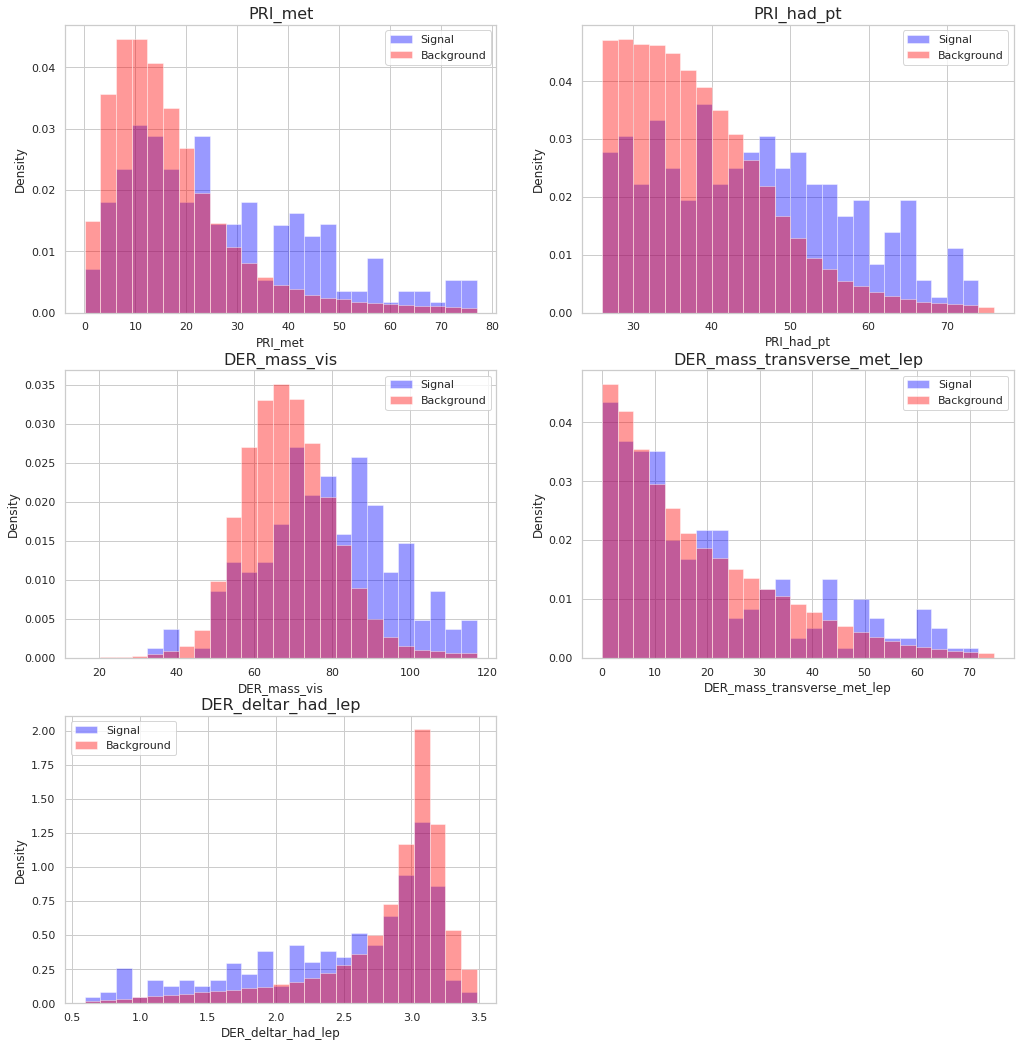

In [12]:
# Show data summary
train_visualize.histogram_dataset()

### Stacked Histogram

The stacked histogram is a visualization technique used to display the distribution of categories within a dataset for a perticular feature. It is particularly useful when comparing the distribution of different groups or classes.

diboson (713,)
diboson (713,)
htautau (30,)
ttbar (8638,)
ttbar (8638,)
ztautau (189193,)
ztautau (189193,)


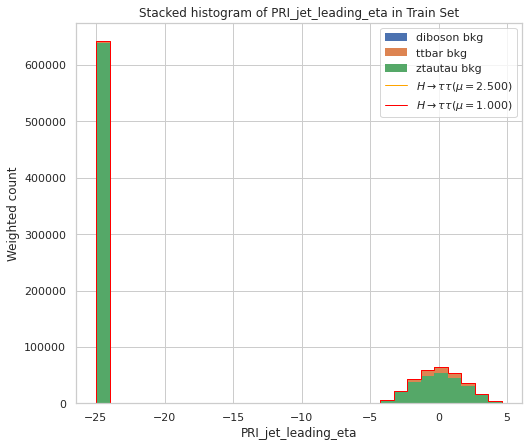

In [13]:
train_visualize.stacked_histogram("PRI_jet_leading_eta",mu_hat=2.5)

/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


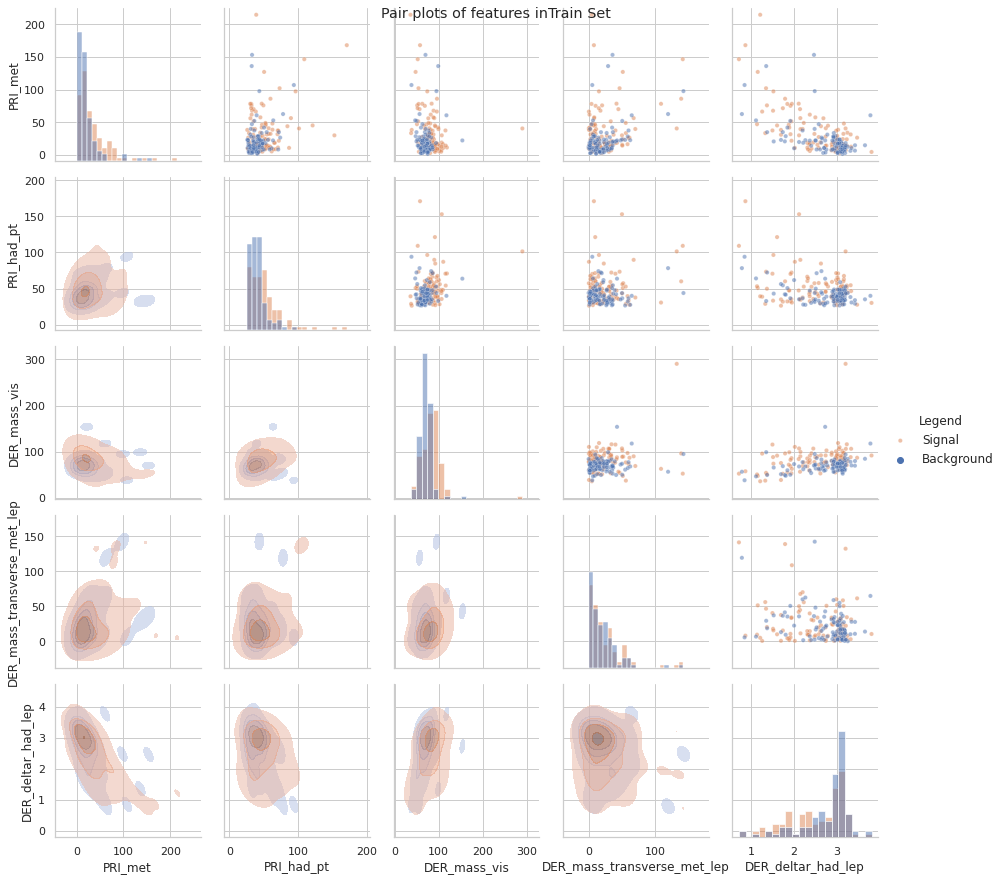

In [14]:
train_visualize.pair_plots(sample_size=100)

In [15]:
syst_train_data = data.get_syst_train_set(tes=0.9, dopostprocess=True) # you can use other systematics like jes, softmet, etc.

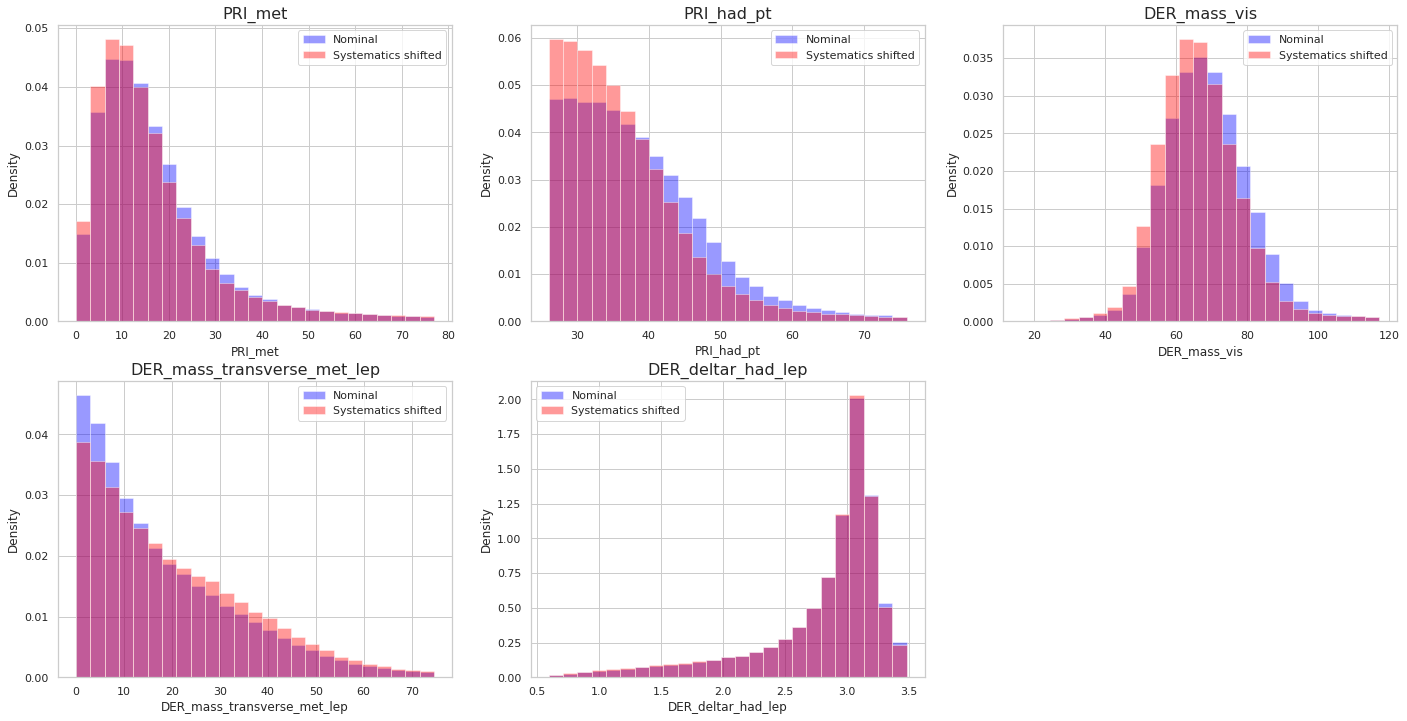

In [16]:
train_visualize.histogram_syst(syst_train_data['data'],syst_train_data['weights'])

For event vise plots we want sytematics plots without without post process cuts

In [17]:
data_vis = data.get_train_set()
# when No systematics parameters are passed, and dopostprocess is false .This mean only derived quantities are calculated
data_vis = systematics(data_vis, dopostprocess=False) 

In [18]:
train_visualize = viz.Dataset_visualise(
    data_set=data_vis,
    columns=[
        "PRI_met",
        "PRI_had_pt",
        "DER_mass_vis",
        "DER_mass_transverse_met_lep",
        "DER_deltar_had_lep",

    ],
    name="Train Set",
)


General Structure of the data object is a dictionary
+-----------------+---------------------------------+-------------------------------------+
| Key             | Value                           | Type                                |
+=================+=================================+=====================================+
| labels          | Array of shape (220790,)        | <class 'pandas.core.series.Series'> |
+-----------------+---------------------------------+-------------------------------------+
| weights         | Array of shape (220790,)        | <class 'pandas.core.series.Series'> |
+-----------------+---------------------------------+-------------------------------------+
| detailed_labels | Array of shape (220790,)        | <class 'pandas.core.series.Series'> |
+-----------------+---------------------------------+-------------------------------------+
| data            | DataFrame of shape (220790, 28) | DataFrame                           |
+-----------------+-------

In [19]:
data_syst = data.get_syst_train_set(tes=0.9) # you can use other systematics like jes, softmet, etc.

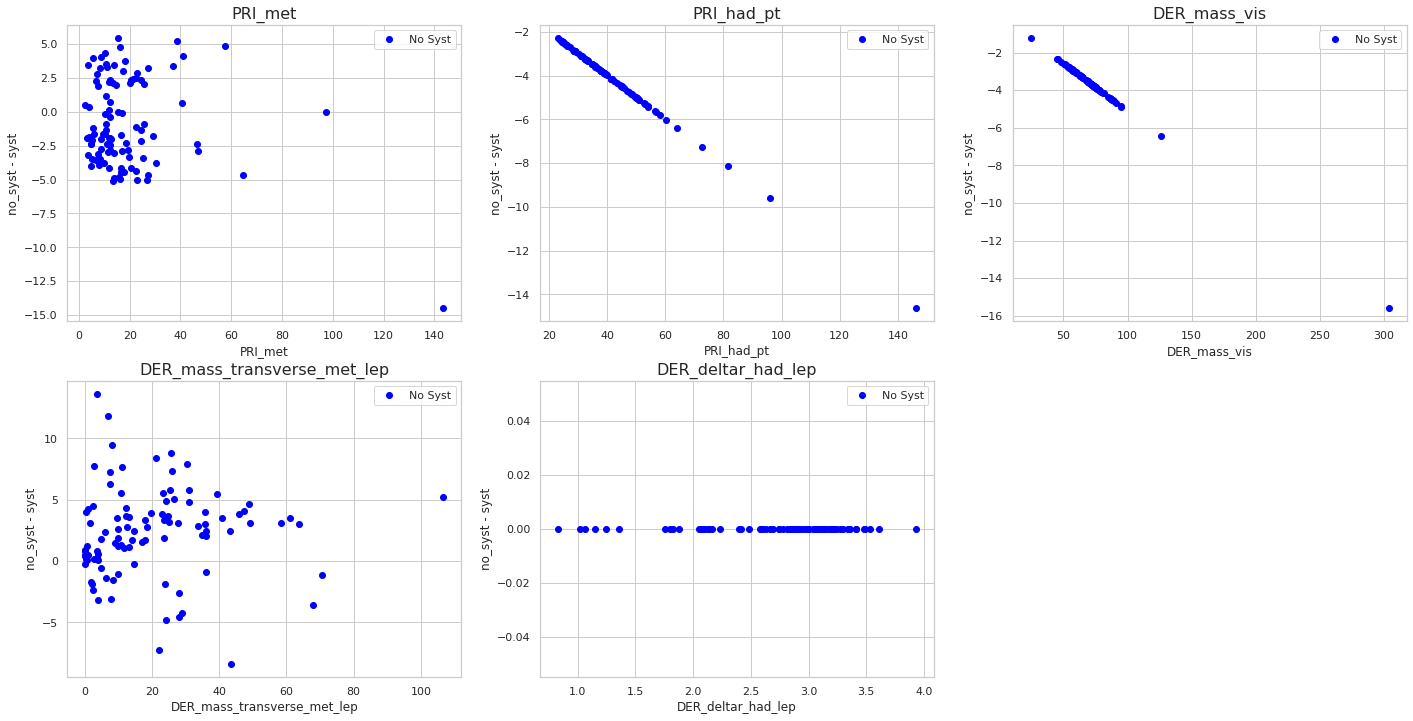

In [20]:
train_visualize.event_vise_syst(data_syst['data'])

***
### Program
***


In [21]:

from ingestion import Ingestion

ingestion = Ingestion(data)


***
## MODEL
***
* For the competition model should be defined as a class and saved a file called model.py.
* Two models are available in this notebook one is a ML + counting method.
    1. Histogram + Likelihood method - set `USE_INTERNAL_HISTOGRAM_MODEL` to true to use this model
    2. ML + counting method - set `USE_INTERNAL_ML_MODEL` to true to use it
        * The same model is available in [simple_stat_only_model](/simple_stat_only_model/), - set `USE_SIMPLE_STAT_ONLY_MODEL` to `True` to use this model
* A slightly more advance model which can work with 1 systematics is available in [simple_one_syst_model](/simple_one_syst_model/) 
    * set `USE_SIMPLE_ONE_SYST_MODEL` to `True` to use this model

In [22]:
USE_INTERNAL_HISTOGRAM_MODEL = True

USE_SIMPLE_STAT_ONLY_MODEL = False
USE_SIMPLE_ONE_SYST_MODEL = False
USE_INTERNAL_ML_MODEL = False


*Notice when you External Models its imported into the notebook*

In [23]:
if USE_SIMPLE_STAT_ONLY_MODEL:
    submission_dir = os.path.join(root_dir, "simple_stat_only_model")
    path.append(submission_dir)
    from model import Model
    
elif USE_SIMPLE_ONE_SYST_MODEL:
    submission_dir = os.path.join(root_dir, "simple_one_syst_model")
    path.append(submission_dir)
    from model import Model


Now we are defining a bunch a helper function for the `Model` class to do statistics and data splting.

#### `calculate_saved_info` Function

Calculates `saved_info` for "mu" computation from a model and training data. 

- **Inputs**:
  - `model`: Predictive model.
  - `train_set`: Dictionary with training data and labels.
  - `file_path`: Optional path to save the results (default is "saved_info.pkl").

- **Returns**: Dictionary with calculated `beta` and `gamma`.


In [24]:
if USE_INTERNAL_ML_MODEL:
    def calculate_saved_info(model, train_set):


        score = model.predict(train_set["data"])

        print("score shape before threshold", score.shape)

        score = score.flatten() > 0.5
        score = score.astype(int)

        label = train_set["labels"]

        print("score shape after threshold", score.shape)

        gamma = np.sum(train_set["weights"] * score * label) + 0.1

        beta = np.sum(train_set["weights"] * score * (1 - label)) - 0.1

        saved_info = {"beta": beta, "gamma": gamma}

        print("saved_info", saved_info)

        return saved_info


#### `compute_mu` Function

Calculates "mu" and its uncertainties from scores and weights. It uses a dictionary for additional parameters. 

- **Inputs**:
  - `score`: Array of scores.
  - `weight`: Array of weights.
  - `saved_info`: Dictionary with "beta" and "gamma".

- **Returns**: A dictionary with "mu_hat", "del_mu_stat", "del_mu_sys", and "del_mu_tot".



In [25]:

if USE_INTERNAL_ML_MODEL:
    def compute_mu(score, weight, saved_info):

        score = score.flatten() > 0.5
        score = score.astype(int)

        mu = (np.sum(score * weight) - saved_info["beta"]) / saved_info["gamma"]
        del_mu_stat = (
            np.sqrt(saved_info["beta"] + saved_info["gamma"]) / saved_info["gamma"]
        )
        del_mu_sys = abs(0.1 * mu)
        del_mu_tot = (1 / 2) * np.sqrt(del_mu_stat**2 + del_mu_sys**2)

        return {
            "mu_hat": mu,
            "del_mu_stat": del_mu_stat,
            "del_mu_sys": del_mu_sys,
            "del_mu_tot": del_mu_tot,
        }



This is a custom `train_test_split()` build around the sklearn train_test_slipt. This is so it works well with the dictionary setting we have and as a bonus also does reweighting which is essential for getting the statistics right.

In [26]:

from sklearn.model_selection import train_test_split as sk_train_test_split

def train_test_split(data_set, test_size=0.2, random_state=42, reweight=False):

    data = data_set["data"].copy()
    train_set = {}
    test_set = {}
    full_size = len(data)

    print(f"Full size of the data is {full_size}")

    for key in data_set.keys():
        if (key != "data") and (key != "settings"):
            data[key] = np.array(data_set[key])

    train_data, test_data = sk_train_test_split(
        data, test_size=test_size, random_state=random_state
    )

    for key in data_set.keys():
        if (key != "data") and (key != "settings"):
            train_set[key] = np.array(train_data.pop(key))
            test_set[key] = np.array(test_data.pop(key))

    train_set["data"] = train_data
    test_set["data"] = test_data

    if reweight is True:
        signal_weight = np.sum(data_set["weights"][data_set["labels"] == 1])
        background_weight = np.sum(data_set["weights"][data_set["labels"] == 0])
        signal_weight_train = np.sum(train_set["weights"][train_set["labels"] == 1])
        background_weight_train = np.sum(train_set["weights"][train_set["labels"] == 0])
        signal_weight_test = np.sum(test_set["weights"][test_set["labels"] == 1])
        background_weight_test = np.sum(test_set["weights"][test_set["labels"] == 0])

        train_set["weights"][train_set["labels"] == 1] = train_set["weights"][
            train_set["labels"] == 1
        ] * (signal_weight / signal_weight_train)
        test_set["weights"][test_set["labels"] == 1] = test_set["weights"][
            test_set["labels"] == 1
        ] * (signal_weight / signal_weight_test)

        train_set["weights"][train_set["labels"] == 0] = train_set["weights"][
            train_set["labels"] == 0
        ] * (background_weight / background_weight_train)
        test_set["weights"][test_set["labels"] == 0] = test_set["weights"][
            test_set["labels"] == 0
        ] * (background_weight / background_weight_test)

    return train_set, test_set


***
## The Model Class
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

#### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [27]:
if USE_INTERNAL_ML_MODEL :
    from xgboost import XGBClassifier
    from sklearn.preprocessing import StandardScaler

    class Model:

        def __init__(self, get_train_set=None, systematics=None):

            self.get_train_set = get_train_set
            self.systematics = systematics
            self.re_train = True
                    
            self.model = XGBClassifier(eval_metric=["error", "logloss", "rmse"],)
            self.name = "model_XGB"
            self.scaler = StandardScaler()
            

        def fit(self):
            """
            Trains the model.

            Params:
                None

            Functionality:
                This function can be used to train a model. If `re_train` is True, it balances the dataset,
                fits the model using the balanced dataset, and saves the model. If `re_train` is False, it
                loads the saved model and calculates the saved information. The saved information is used
                to compute the train results.

            Returns:
                None
            """


            train_set = self.get_train_set() # train_set is a dictionary with data, labels, and weights
            
            training_set, holdout_set = train_test_split(
                train_set, test_size=0.5, random_state=42, reweight=True
            )
            
            del train_set
            
            training_set = self.systematics(training_set)

            weights_train = training_set["weights"].copy()
            train_labels = training_set["labels"].copy()
            class_weights_train = (
                weights_train[train_labels == 0].sum(),
                weights_train[train_labels == 1].sum(),
            )

            for i in range(len(class_weights_train)):  # loop on B then S target
                # training dataset: equalize number of background and signal
                weights_train[train_labels == i] *= (
                    max(class_weights_train) / class_weights_train[i]
                )
                # test dataset : increase test weight to compensate for sampling

            training_set["weights"] = weights_train
                    
            self.scaler.fit_transform(training_set["data"])

            X_train_data = self.scaler.transform(training_set["data"])
            self.model.fit(X_train_data,training_set["labels"], training_set["weights"])
            
            holdout_set = self.systematics(holdout_set)
            
            self.saved_info = calculate_saved_info(self.model, holdout_set)

            holdout_score = self.model.predict(holdout_set["data"])
            holdout_results = compute_mu(
                holdout_score, holdout_set["weights"], self.saved_info
            )
                
            print("Holdout Results: ")
            for key in holdout_results.keys():
                print("\t", key, " : ", holdout_results[key])


        def predict(self, test_set):
            """
            Predicts the values for the test set.

            Parameters:
                test_set (dict): A dictionary containing the test data, and weights.

            Returns:
                dict: A dictionary with the following keys:
                * 'mu_hat': The predicted value of mu.
                * 'delta_mu_hat': The uncertainty in the predicted value of mu.
                * 'p16': The lower bound of the 16th percentile of mu.
                * 'p84': The upper bound of the 84th percentile of mu.
            """

            test_data = test_set["data"]
            test_weights = test_set["weights"]

            test_data = self.scaler.transform(test_data)
            predictions = self.model.predict_proba(test_data)[:, 1]
        
            result_mu_cal = compute_mu(predictions, test_weights, self.saved_info)

            print("Test Results: ", result_mu_cal)

            result = {
                "mu_hat": result_mu_cal["mu_hat"],
                "delta_mu_hat": result_mu_cal["del_mu_tot"],
                "p16": result_mu_cal["mu_hat"] - result_mu_cal["del_mu_tot"],
                "p84": result_mu_cal["mu_hat"] + result_mu_cal["del_mu_tot"],
            }

            return result



In [28]:
if USE_INTERNAL_HISTOGRAM_MODEL :
    import matplotlib.gridspec as gridspec
    import matplotlib.pyplot as plt

    class Model:
        def __init__(self, get_train_set=None, systematics=None):
            """
            Parameters:
            - get_train_set (function): A function that returns the training set.
            - systematics (list): systematics paramter

            Attributes:
            - get_train_set (function): A function that returns the training set.
            - systematics (list): A list of systematics.
            - n_bins (int): Number of bins.
            - mu_range (numpy array): Range of mu values.
            - epsilon (float): A small value used for numerical stability.
            - plot (bool): Flag indicating whether to plot the results.
            """
            self.get_train_set = get_train_set
            self.systematics = systematics

            # Default values for other attributes
            self.n_bins = 10
            self.mu_range = np.linspace(0.001, 10.0, 400)
            self.epsilon = 1e-20
            self.plot = True
            

        def fit(self):
            """
            Trains the model.

            Params:
                None

            Functionality:
                This function can be used to train a model. If `re_train` is True, it balances the dataset,
                fits the model using the balanced dataset, and saves the model. If `re_train` is False, it
                loads the saved model and calculates the saved information. The saved information is used
                to compute the train results.

            Returns:
                None
            """

            # Get the training set
            train_set = self.get_train_set() # train_set is a dictionary with data, labels, and weights

            # Apply systematics to the training set
            train_set = systematics(train_set)
            
            # Separate the signal and background data and weights
            data_sig = train_set["data"].values[train_set["labels"]==1, 0]
            weights_sig = train_set["weights"][train_set["labels"]==1]

            data_bkg = train_set["data"].values[train_set["labels"]==0, 0]
            weights_bkg = train_set["weights"][train_set["labels"]==0]

            # Set the bin range for histogram calculation
            self.bin_range=(
                1.05*min(np.min(data_sig), np.min(data_bkg)),
                0.95*max(np.max(data_sig), np.max(data_bkg))
            )
            
            # Calculate the signal template histogram
            self.template_sig, _ = np.histogram(
                data_sig,
                weights=weights_sig,
                range=self.bin_range, 
                bins=self.n_bins, 
                density=False
            )
            
            # Calculate the background template histogram
            self.template_bkg, _ = np.histogram(
                data_bkg,
                weights=weights_bkg,
                range=self.bin_range, 
                bins=self.n_bins, 
                density=False
            )
            
            


        def predict(self, test_set):
            """
            Predicts the values for the test set.

            Parameters:
                test_set (dict): A dictionary containing the test data, and weights.

            Returns:
                dict: A dictionary with the following keys:
                * 'mu_hat': The predicted value of mu.
                * 'delta_mu_hat': The uncertainty in the predicted value of mu.
                * 'p16': The lower bound of the 16th percentile of mu.
                * 'p84': The upper bound of the 84th percentile of mu.
            """
            # Convert test data and weights to numpy arrays, and select the first column of the data (Lepton_pt)
            test_data = np.array(test_set["data"])[:, 0]
            test_weights = np.array(test_set["weights"])[:]

            # Calculate the histogram of test data
            hist_test, _ = np.histogram(
                test_data,
                weights=test_weights,
                range=self.bin_range, 
                bins=self.n_bins, 
                density=False
            )        

            # Initialize an array to store the negative log-likelihood values
            nll2D = np.zeros((len(self.mu_range)))

            # Iterate over mu values and calculate the negative log-likelihood
            for mu_iter, mu_val in enumerate(self.mu_range):
                N = hist_test + self.epsilon
                nexp = mu_val * self.template_sig + self.template_bkg + self.epsilon

                # Calculate the negative log-likelihood for fixed N, variable nexp
                nll = - (N * np.log(nexp) - nexp)
                nll2D[mu_iter] = np.sum(nll)

            # Calculate the difference between the negative log-likelihood and its minimum value
            nll_diff = nll2D-np.min(nll2D)
            
            # Create a mask to select only NLL values withing 4 of the minimum value for the fit
            fitrange_mask = nll_diff < 4.0
            
            # Fit a parabola to the selected data points
            z = np.polyfit(
                self.mu_range[fitrange_mask], 
                nll_diff[fitrange_mask], 
                2,
            )

            poly = np.poly1d(z)

            deriv1 = poly.deriv()
            
            # Find the minimum value of nll_diff and its corresponding mu value
            min_mu_ind = np.argmin(nll_diff)
            central = self.mu_range[min_mu_ind]

            # Find the extrema of the polynomial and select the minimum value closest to the mu with the minimum nll_diff
            extrema = (deriv1).roots
            minimum = extrema[np.argsort(np.abs(extrema-central))][0]

            # Find the intersections of the polynomial with the threshold value
            # Threadhold 0.5 corresponds to 1 sigma in the chi2 distribution
            threshold = .5
            intersects = (poly - threshold).roots
            
            # Select 2 intersections closest to central value (only needed for polynomials with order > 2)
            intersects = intersects[np.argsort(np.abs(intersects-central))][:2] 

            # Ensure first intersect is smaller than second intersect
            intersects = np.sort(intersects)

            # Plot the results if self.plot is True
            if self.plot:
                fig = plt.figure(figsize=(7,5))
                outer = gridspec.GridSpec(1, 1, wspace=0.2, hspace=0.2)
                subplot = fig.add_subplot(outer[0])

                subplot.plot(self.mu_range, nll_diff, label='Nll_diff')
                subplot.plot(self.mu_range, poly(self.mu_range), label='Fit')
                subplot.set_ylim(-0.0, 4.5)

                subplot.set_ylabel('NLL Difference')
                subplot.set_xlabel('mu')

                subplot.legend()
                plt.show()

            # Create a dictionary to store the results
            result = {
                "mu_hat": minimum,
                "delta_mu_hat": abs(intersects[1] - intersects[0])/2,
                "p16": intersects[0],
                "p84": intersects[1],
            }

            return result



Now that you can defined you model you can submit it with the ingestion function. 

In [29]:

# initialize submission
ingestion.init_submission(Model)

2024-09-16 18:43:45,036 - ingestion            - INFO     - Initializing Submmited Model


The `fit_submission` then calls fit method of the model and concludes the training phase of the model

In [30]:

# fit submission
ingestion.fit_submission()

2024-09-16 18:43:45,082 - ingestion            - INFO     - Fitting Submmited Model
2024-09-16 18:43:45,243 - datasets             - INFO     - Train data loaded successfully


In [31]:
# load test set
data.load_test_set()

2024-09-16 18:43:45,516 - datasets             - INFO     - Test data loaded successfully


### TEST SETTINGS

Here you can set the test settings. This will determine which all systematics are applied and how many pseudo experiments are run

⚠️ Note: As you can see by default *tes* or *Tau-hadron Energy scale systematics* is applied, when running stat-only method turn this to `False` to get meaningfull results.

In [32]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 4 , # Number of pseudo-experiments to run per set
"num_of_sets" : 3, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

In [33]:
test_settings = TEST_SETTINGS.copy()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)

Next is the prediction phase this is where the pseudo experiments are defined and the model is **repeatedly** called to Evalute each pseudo dataset. 

**⚠️ Note: In the Real Challenge the prediction step is parallelised.**

2024-09-16 18:43:45,626 - ingestion            - INFO     - Calling predict method of submitted model


/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


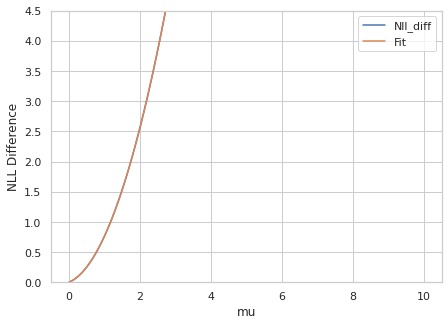

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


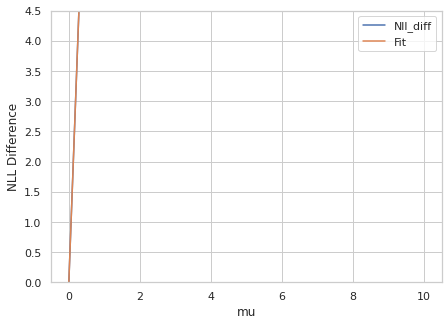

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


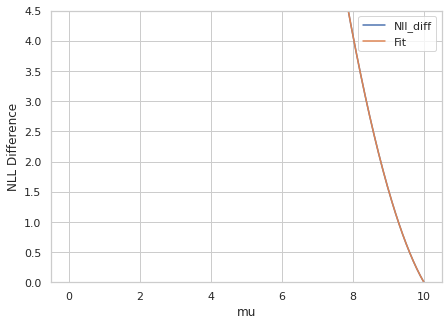

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


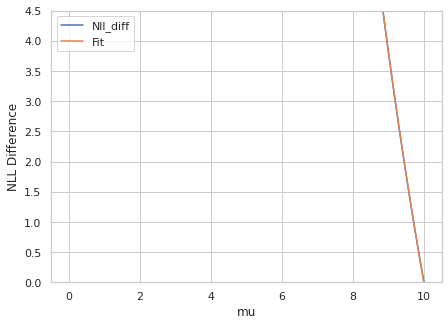

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


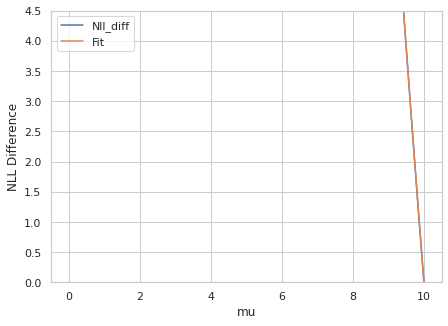

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


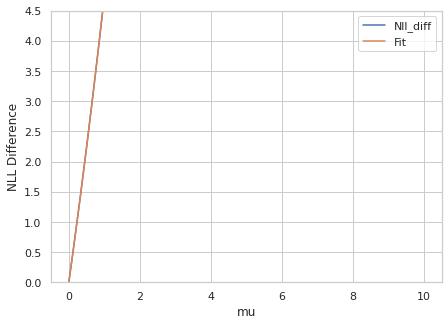

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


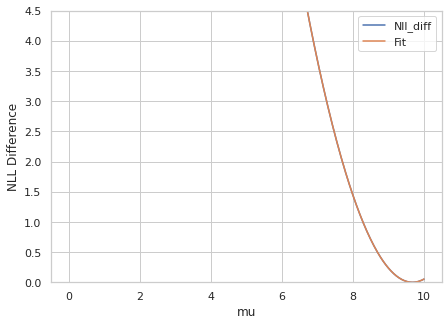

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


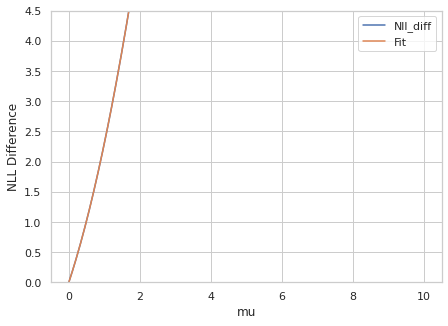

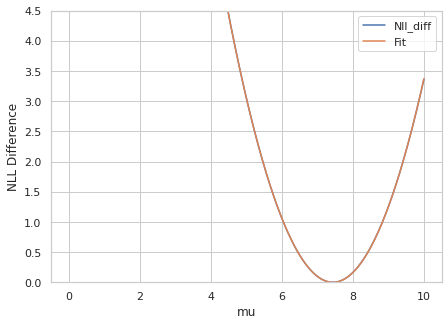

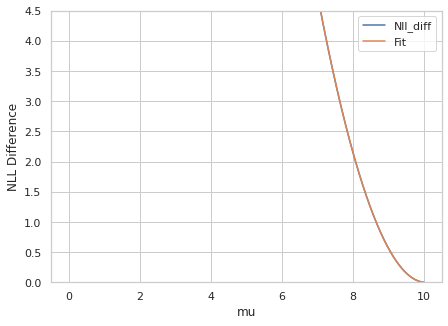

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


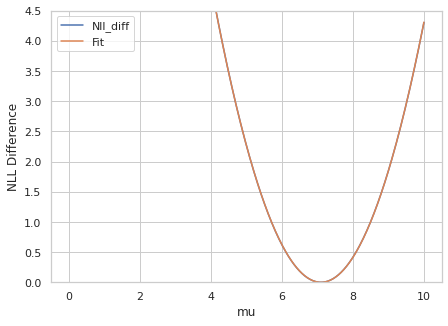

/data/atlas/chakkappai/FairUniverse/HEP-Challenge/ingestion_program/systematics.py:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, "weights"] = new_weights[new_weights > 0]


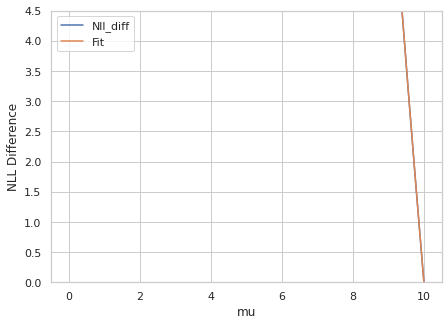

In [34]:

# predict submission
ingestion.predict_submission(test_settings)

The Last step combines the result from all the pseudo experiments and prepare it for scoring.

In [35]:
ingestion.compute_result()

2024-09-16 18:44:03,637 - ingestion            - INFO     - Computing Ingestion Result


In [36]:

# save result
!rm -rf $output_dir/*
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [37]:
from score import Scoring

In [38]:
# Initialize Score
score = Scoring()

In [39]:
score.load_ingestion_results(output_dir)

2024-09-16 18:44:03,926 - score                - INFO     - Read ingestion results from /data/atlas/chakkappai/FairUniverse/HEP-Challenge/sample_result_submission


The next stage computes the score the submitted model by evaluting the results from ingestion.
* Please note the plots show **average $\mu$** and **NOT** the **true $\mu$**. 
* Another plot is provided below exclusively for the starting kit with both the **average $\mu$** and the **true $\mu$.**

2024-09-16 18:44:03,969 - score                - INFO     - Computing scores


------------------
Set 0
------------------
MAE (avg): 9.475555075382179
RMSE (avg): 32.04423971862689
Interval: 3.802991815608139
Coverage: 0.0
Quantiles Score: -1.9013082041272062
------------------
Set 1
------------------
MAE (avg): 14.311774556574841
RMSE (avg): 74.72143606114255
Interval: 12.8683541051546
Coverage: 0.0
Quantiles Score: -3.120106045237946
------------------
Set 2
------------------
MAE (avg): 21.054304550506593
RMSE (avg): 138.87045582815654
Interval: 6.085173506861747
Coverage: 0.0
Quantiles Score: -2.371276771216078


Overall Score
[*] --- RMSE: 81.879
[*] --- MAE: 14.947
[*] --- Interval: 7.586
[*] --- Coverage: 0.0
[*] --- Quantiles score: -6.539
[*] --- Ingestion duration: None
[✔]


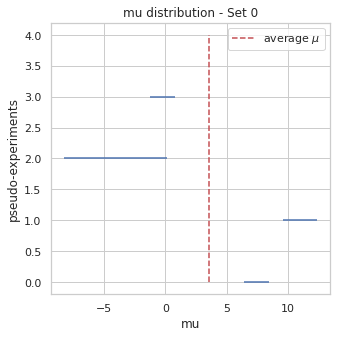

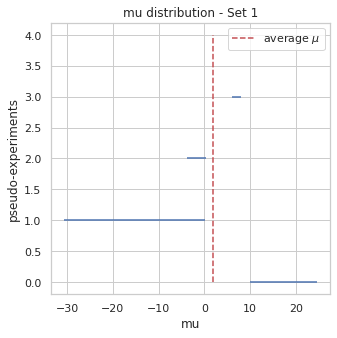

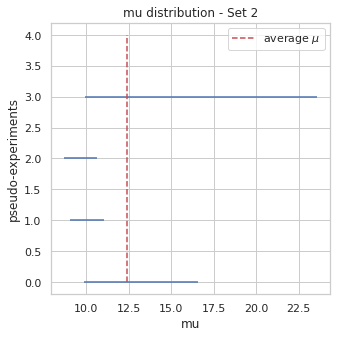

In [40]:
# Compute Score
score.compute_scores(test_settings)

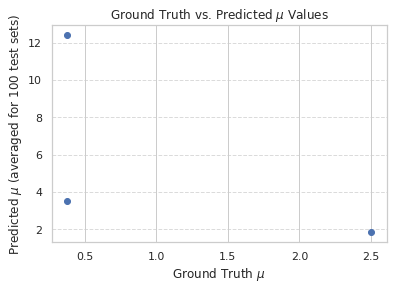

In [41]:
# Visualize scatter plot of ground truth mu and predicted mu
viz.visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

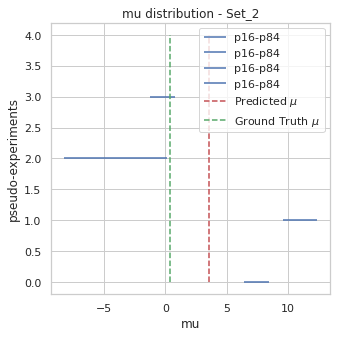

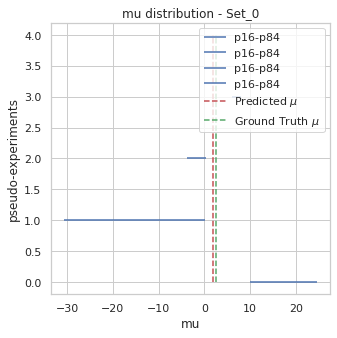

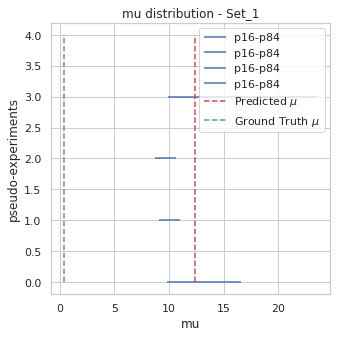

In [42]:
# Visualize coverage
viz.visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [43]:
def zipdir(archivename, basedir):
    '''Zip directory, from J.F. Sebastian http://stackoverflow.com/'''
    assert os.path.isdir(basedir)
    with closing(ZipFile(archivename, "w", ZIP_DEFLATED)) as z:
        for root, dirs, files in os.walk(basedir):
            # NOTE: ignore empty directories
            for fn in files:
                if fn[-4:] != '.zip' and fn != '.DS_Store':
                    absfn = os.path.join(root, fn)
                    zfn = absfn[len(basedir):]  # XXX: relative path
                    z.write(absfn, zfn)

In [44]:
if not (USE_INTERNAL_ML_MODEL or USE_INTERNAL_HISTOGRAM_MODEL):
    the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
    code_submission = 'Submission_' + the_date + '.zip'
    zipdir(code_submission, submission_dir)
    print("Submit : " + code_submission + " to the competition")
    print("You can find the zip file in `HEP-Challenge/")